In [1]:
import pandas as pd
import numpy as np

import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco/python")

from geo import closest_point_on_track, closest_distance_dom_track
from geo import __c

In [2]:
bp = '/home/storage2/hans/i3files/21217'

# 1 TeV to 10 TeV muons (at detector boundary)
df_meta = pd.read_feather(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'))
df_pulses = pd.read_feather(os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'))
geo = pd.read_csv('/home/storage/hans/jax_reco/detector_geometry.csv')

In [3]:
def get_event_data(meta: pd.DataFrame, 
                   data: pd.DataFrame, 
                   geo: pd.DataFrame, 
                   event_index: int = 0) -> np.ndarray:
    
    ev_idx = event_index
    event_meta = meta.iloc[ev_idx]
    event_data = (data.iloc[int(event_meta.idx_start): int(event_meta.idx_end + 1)]).copy(deep=True)
    return event_meta, event_data

In [266]:
meta, pulses = get_event_data(df_meta, df_pulses, geo, event_index=6)

In [267]:
meta

event_id                   2.121700e+09
idx_start                  9.180000e+02
idx_end                    9.860000e+02
n_channel_HLC              2.800000e+01
neutrino_energy            1.714579e+03
muon_energy                1.507896e+03
muon_energy_at_detector    1.507896e+03
muon_energy_lost           8.556311e+02
q_tot                      4.745000e+01
n_channel                  4.300000e+01
muon_zenith                2.052723e+00
muon_azimuth               3.510110e+00
muon_time                  9.512693e+03
muon_pos_x                -3.115061e+02
muon_pos_y                -2.378587e+02
muon_pos_z                -2.061577e+02
spline_mpe_zenith          2.059104e+00
spline_mpe_azimuth         3.509308e+00
spline_mpe_time            1.109346e+04
spline_mpe_pos_x           7.891891e+01
spline_mpe_pos_y          -8.532626e+01
spline_mpe_pos_z           1.197033e+01
Name: 6, dtype: float64

In [268]:
print(pulses)

         event_id  sensor_id     time  charge  is_HLC
918  2.121700e+09      878.0  10379.0   0.375     1.0
919  2.121700e+09      878.0  10971.0   0.675     1.0
920  2.121700e+09      879.0  10387.0   1.175     1.0
921  2.121700e+09      886.0  11734.0   0.525     0.0
922  2.121700e+09     1357.0  10617.0   1.175     0.0
..            ...        ...      ...     ...     ...
982  2.121700e+09     2355.0  13990.0   0.375     1.0
983  2.121700e+09     2356.0  13111.0   1.225     1.0
984  2.121700e+09     2835.0  13321.0   0.575     0.0
985  2.121700e+09     2839.0  13142.0   1.025     0.0
986  2.121700e+09     2952.0  13605.0   1.175     0.0

[69 rows x 5 columns]


In [269]:
print(geo)

      sensor_id       x       y       z
0             0 -256.14 -521.08  496.03
1             1 -256.14 -521.08  479.01
2             2 -256.14 -521.08  461.99
3             3 -256.14 -521.08  444.97
4             4 -256.14 -521.08  427.95
...         ...     ...     ...     ...
5155       5155  -10.97    6.72 -472.39
5156       5156  -10.97    6.72 -479.39
5157       5157  -10.97    6.72 -486.40
5158       5158  -10.97    6.72 -493.41
5159       5159  -10.97    6.72 -500.73

[5160 rows x 4 columns]


In [270]:
def get_loc_highest_charge_dom(pulses: pd.DataFrame, geo: pd.DataFrame):
    qtot_per_dom = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
    sensor_id = qtot_per_dom.loc[qtot_per_dom['charge'].idxmax()]['sensor_id']
    return geo.iloc[[sensor_id]][['x', 'y', 'z']].to_numpy().squeeze()

def get_qtot_per_dom_with_coords(pulses: pd.DataFrame, geo: pd.DataFrame):
    df = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
    df = df.merge(geo.iloc[df['sensor_id']], on='sensor_id', how='outer')
    return df
    
def get_xyz_from_zenith_azimuth(x):
    zenith, azimuth = x
    x = np.zeros(3)
    x[0] = np.sin(zenith) * np.cos(azimuth)
    x[1] = np.sin(zenith) * np.sin(azimuth)
    x[2] = np.cos(zenith)
    # flip vector by 180deg
    x *= -1.0
    return x

def get_min_t_per_dom_with_coords(pulses: pd.DataFrame, geo: pd.DataFrame):
    df = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
    df = df.merge(geo.iloc[df['sensor_id']], on='sensor_id', how='outer')
    return df

def get_per_dom_info(pulses: pd.DataFrame, geo: pd.DataFrame):
    df_qtot = pulses[['sensor_id', 'charge']].groupby(by=['sensor_id'], as_index=False).sum()
    df_tmin = pulses[['sensor_id', 'time']].groupby(by=['sensor_id'], as_index=False).min()
    df = df_qtot.merge(geo.iloc[df_qtot['sensor_id']], on='sensor_id', how='outer')
    df['time'] = df_tmin['time'].values
    return df
    

In [271]:
dom_info = get_qtot_per_dom_with_coords(pulses, geo)
dom_info_t = get_min_t_per_dom_with_coords(pulses, geo)
dom_info_all = get_per_dom_info(pulses, geo)

In [272]:
print(dom_info)

    sensor_id  charge       x       y       z
0       878.0   1.050 -290.66 -307.38 -142.64
1       879.0   1.175 -290.66 -307.38 -159.66
2       886.0   0.525 -290.66 -307.38 -278.81
3      1357.0   1.175 -368.93 -210.23 -129.23
4      1360.0   1.575 -368.93 -210.23 -180.30
5      1361.0   0.775 -368.93 -210.23 -197.32
6      1363.0   0.825 -368.93 -210.23 -231.36
7      1364.0   0.775 -368.93 -210.23 -248.38
8      1418.0   2.950 -245.65 -190.49 -144.92
9      1419.0   3.375 -245.65 -190.49 -161.95
10     1420.0   2.100 -245.65 -190.49 -178.97
11     1421.0   3.600 -245.65 -190.49 -195.99
12     1422.0   0.275 -245.65 -190.49 -213.01
13     1475.0   0.375 -121.77 -171.03  -93.45
14     1476.0   1.750 -121.77 -171.03 -110.47
15     1477.0   1.800 -121.77 -171.03 -127.49
16     1526.0   1.125    1.71 -150.63   54.72
17     1530.0   0.625    1.71 -150.63  -13.37
18     1533.0   1.500    1.71 -150.63  -64.43
19     1587.0   0.675  124.97 -131.25   34.09
20     1903.0   0.375 -447.74 -113

In [273]:
print(dom_info_t['time'])

0     10379.0
1     10387.0
2     11734.0
3     10617.0
4      9946.0
5     10741.0
6     10092.0
7     10269.0
8      9952.0
9      9885.0
10     9870.0
11     9912.0
12     9919.0
13    10439.0
14    10368.0
15    10371.0
16    11405.0
17    11061.0
18    10888.0
19    12274.0
20     9921.0
21    10467.0
22    11909.0
23    11425.0
24    12190.0
25    12508.0
26    11653.0
27    11606.0
28    11642.0
29    12521.0
30    12069.0
31    11993.0
32    12000.0
33    12088.0
34    12537.0
35    13217.0
36    13063.0
37    13139.0
38    13990.0
39    13111.0
40    13321.0
41    13142.0
42    13605.0
Name: time, dtype: float64


In [274]:
print(dom_info_all.columns.values)

['sensor_id' 'charge' 'x' 'y' 'z' 'time']


In [275]:
dom_info['charge'] = np.round(dom_info['charge']+0.5)

In [276]:
print(dom_info)

    sensor_id  charge       x       y       z
0       878.0     2.0 -290.66 -307.38 -142.64
1       879.0     2.0 -290.66 -307.38 -159.66
2       886.0     1.0 -290.66 -307.38 -278.81
3      1357.0     2.0 -368.93 -210.23 -129.23
4      1360.0     2.0 -368.93 -210.23 -180.30
5      1361.0     1.0 -368.93 -210.23 -197.32
6      1363.0     1.0 -368.93 -210.23 -231.36
7      1364.0     1.0 -368.93 -210.23 -248.38
8      1418.0     3.0 -245.65 -190.49 -144.92
9      1419.0     4.0 -245.65 -190.49 -161.95
10     1420.0     3.0 -245.65 -190.49 -178.97
11     1421.0     4.0 -245.65 -190.49 -195.99
12     1422.0     1.0 -245.65 -190.49 -213.01
13     1475.0     1.0 -121.77 -171.03  -93.45
14     1476.0     2.0 -121.77 -171.03 -110.47
15     1477.0     2.0 -121.77 -171.03 -127.49
16     1526.0     2.0    1.71 -150.63   54.72
17     1530.0     1.0    1.71 -150.63  -13.37
18     1533.0     2.0    1.71 -150.63  -64.43
19     1587.0     1.0  124.97 -131.25   34.09
20     1903.0     1.0 -447.74 -113

In [277]:
qmax_sensor_pos = get_loc_highest_charge_dom(pulses, geo)
print(qmax_sensor_pos)
track_pos = np.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
spline_mpe_pos = np.array([meta['spline_mpe_pos_x'], meta['spline_mpe_pos_y'], meta['spline_mpe_pos_z']])
print(track_pos)
source_dir = np.array([meta['muon_zenith'], meta['muon_azimuth']])
track_dir_xyz = get_xyz_from_zenith_azimuth(source_dir)

[194.34 -30.92  95.6 ]
[-311.50606825 -237.85870606 -206.15769315]


In [278]:
closest_approach_point = closest_point_on_track(qmax_sensor_pos, track_pos, track_dir_xyz)

In [279]:
print(closest_approach_point)

[204.34593518 -38.65789412  83.0838631 ]


In [280]:
muon_travel_time = np.linalg.norm(closest_approach_point - track_pos) / __c

In [281]:
print(muon_travel_time)

2081.624183321504


In [282]:
print(meta['muon_time']+muon_travel_time)

11594.317307425796


In [283]:
print(meta['muon_time'])

9512.693124104291


In [284]:
print(meta['spline_mpe_time'])

11093.462032296306


In [285]:
pos_spline_mpe = np.array([meta['spline_mpe_pos_x'], 
                           meta['spline_mpe_pos_y'], 
                           meta['spline_mpe_pos_z']])

In [286]:
print(np.linalg.norm(pos_spline_mpe - closest_approach_point))

151.54870456800663


In [287]:
print(closest_distance_dom_track(pos_spline_mpe, track_pos, track_dir_xyz))

1.9229467429960854


In [288]:
from geo import cherenkov_cylinder_coordinates_v, convert_spherical_to_cartesian_direction
from geo import closest_point_on_track_v

In [289]:
track_dir_xyz_ = -1 * convert_spherical_to_cartesian_direction(source_dir)

In [290]:
print(track_dir_xyz, track_dir_xyz_)

[0.82661274 0.31920382 0.46348711] [0.82661274 0.31920382 0.46348711]


In [291]:
charges = dom_info['charge'].values
dom_positions = dom_info[['x', 'y', 'z']].to_numpy()

In [292]:
geo_time, closest_approach_dist, closest_approach_z = cherenkov_cylinder_coordinates_v(dom_positions, track_pos, track_dir_xyz)

In [293]:
print(geo_time)

[ 352.46210094  300.87823342  147.34040575  279.86135531   95.07726828
   42.28129929  -32.8743559   -50.38415991  405.58097509  360.32188593
  343.35126045  346.9518161   358.23672262  794.63239311  772.23675203
  786.30627569 1612.5421232  1364.09741834 1291.19148735 1857.17568932
  200.84694688  665.68295549 1782.35756637 1675.50375462 2405.26868545
 2198.35309754 2133.27915136 2086.85038424 2098.33542732 2130.71384793
 2527.18642187 2477.36954348 2477.15261377 2491.36745092 2959.37791695
 3580.82067153 3532.11822681 3498.85822026 3483.97988165 3482.93714956
 3221.01314387 3068.43329919 3832.38897242]


In [294]:
print(closest_approach_dist)

[ 93.28990212  84.58448405  95.15040182  99.84870675  63.39190535
  54.26893114  46.50796004  49.54069624  27.17547411  20.65420114
  23.87267863  34.17771033  47.12991957   8.98131787  10.3309349
  24.24241529  87.05803281  37.73550066  39.81421411  58.13143309
 166.19019659 147.82502141  67.84538709  67.29409326  75.23339238
  31.14719724  17.79458983  10.86504928  32.95620773  62.23958772
  17.12499529   9.02828627  18.01823465  31.97977399  26.5711338
  44.33932701  36.62652859  34.2334867   38.17806078  46.88352898
 125.75685323 109.45875088  62.78405091]


In [295]:
print(closest_approach_z)

[-194.81162355 -198.4678651  -224.06370415 -207.54498923 -218.51586208
 -222.17210363 -229.48458673 -233.14082828 -160.76347888 -164.42186864
 -168.07811019 -171.73435174 -175.39059329  -99.36618753 -103.02242908
 -106.67867063  -17.20995262  -31.83706702  -42.80579167   28.44942208
 -245.28290231 -173.28636605   14.13532123   -0.48964497   97.7088293
   86.74010465   83.0838631    79.42762155   72.11299025   64.80050715
  138.08733609  134.43109454  130.77485299  127.11861144  194.33021494
  273.51284102  269.85659947  266.20035792  262.54196817  258.88572662
  190.6778156   176.0507012   301.02855488]


In [296]:
print(geo_time)

[ 352.46210094  300.87823342  147.34040575  279.86135531   95.07726828
   42.28129929  -32.8743559   -50.38415991  405.58097509  360.32188593
  343.35126045  346.9518161   358.23672262  794.63239311  772.23675203
  786.30627569 1612.5421232  1364.09741834 1291.19148735 1857.17568932
  200.84694688  665.68295549 1782.35756637 1675.50375462 2405.26868545
 2198.35309754 2133.27915136 2086.85038424 2098.33542732 2130.71384793
 2527.18642187 2477.36954348 2477.15261377 2491.36745092 2959.37791695
 3580.82067153 3532.11822681 3498.85822026 3483.97988165 3482.93714956
 3221.01314387 3068.43329919 3832.38897242]


In [297]:
closest_point = closest_point_on_track_v(dom_positions, track_pos, track_dir_xyz)

In [298]:
print(closest_point)

[[-2.91270758e+02 -2.30044662e+02 -1.94811624e+02]
 [-2.97791534e+02 -2.32562717e+02 -1.98467865e+02]
 [-3.43440800e+02 -2.50190585e+02 -2.24063704e+02]
 [-3.13980261e+02 -2.38814138e+02 -2.07544989e+02]
 [-3.33546422e+02 -2.46369784e+02 -2.18515862e+02]
 [-3.40067198e+02 -2.48887839e+02 -2.22172104e+02]
 [-3.53108751e+02 -2.53923950e+02 -2.29484587e+02]
 [-3.59629528e+02 -2.56442005e+02 -2.33140828e+02]
 [-2.30547106e+02 -2.06595687e+02 -1.60763479e+02]
 [-2.37071713e+02 -2.09115222e+02 -1.64421869e+02]
 [-2.43592490e+02 -2.11633277e+02 -1.68078110e+02]
 [-2.50113266e+02 -2.14151333e+02 -1.71734352e+02]
 [-2.56634043e+02 -2.16669388e+02 -1.75390593e+02]
 [-1.21047225e+02 -1.64311340e+02 -9.93661875e+01]
 [-1.27568002e+02 -1.66829395e+02 -1.03022429e+02]
 [-1.34088778e+02 -1.69347451e+02 -1.06678671e+02]
 [ 2.54754906e+01 -1.07730298e+02 -1.72099526e+01]
 [-6.11446482e-01 -1.17803999e+02 -3.18370670e+01]
 [-2.01737758e+01 -1.25358166e+02 -4.28057917e+01]
 [ 1.06907357e+02 -7.62846624e+

In [299]:
muon_travel_times = jax.numpy.linalg.norm(track_pos - closest_point, axis=1)/__c

In [300]:
print(muon_travel_times)

[  81.65580763   55.34243506  128.86663313    9.98414298   88.93972093
  115.2530935   167.87983862  194.19321118  326.69473719  300.36590436
  274.0525318   247.73915924  221.42578668  768.56100332  742.24763076
  715.93425819 1359.82599174 1254.55704123 1175.61692355 1688.42904514
  281.57773253  236.56956598 1585.41280197 1480.15931172 2186.87767357
 2107.93755588 2081.62418332 2055.31081076 2002.66860537 1950.04186025
 2477.4751842  2451.16181164 2424.84843908 2398.53506652 2882.24598638
 3452.11039827 3425.7970257  3399.48365314 3373.15482032 3346.84144775
 2855.96026563 2750.69131511 3650.13649152]


In [301]:
print(dom_info_t['time'].values - (geo_time + meta['muon_time']))

[ 513.84477496  573.42864247 2073.96647015  824.44552058  338.22960761
 1186.0255766   612.18123179  806.69103581   33.72590081   11.98498996
   13.95561545   52.3550598    48.07015327  131.67448278   83.07012387
   72.0006002   279.7647527   184.20945755   84.11538855  904.13118658
  207.45992901  288.62392041  613.94930952  236.80312127  272.03819045
  796.95377835    7.02772454    6.45649166   30.97144858  877.59302797
   29.12045402    2.93733241   10.15426213   83.93942497   64.92895895
  123.48620436   18.18864908  127.44865564  993.32699425  115.36972633
  587.29373202  560.8735767   259.91790347]


In [302]:
print(closest_approach_dist)

[ 93.28990212  84.58448405  95.15040182  99.84870675  63.39190535
  54.26893114  46.50796004  49.54069624  27.17547411  20.65420114
  23.87267863  34.17771033  47.12991957   8.98131787  10.3309349
  24.24241529  87.05803281  37.73550066  39.81421411  58.13143309
 166.19019659 147.82502141  67.84538709  67.29409326  75.23339238
  31.14719724  17.79458983  10.86504928  32.95620773  62.23958772
  17.12499529   9.02828627  18.01823465  31.97977399  26.5711338
  44.33932701  36.62652859  34.2334867   38.17806078  46.88352898
 125.75685323 109.45875088  62.78405091]


Text(0, 0.5, 'delay time [ns]')

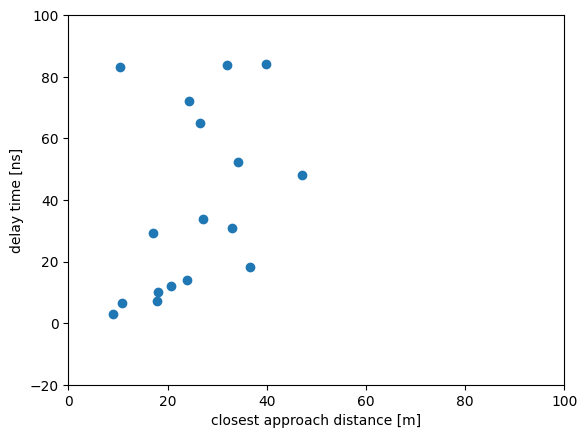

In [303]:
import matplotlib.pyplot as plt
plt.scatter(closest_approach_dist, dom_info_t['time'].values - (geo_time + meta['muon_time']))
plt.xlim([0, 100])
plt.ylim([-20, 100])
plt.xlabel('closest approach distance [m]')
plt.ylabel('delay time [ns]')

In [304]:
print(np.min(dom_info_t['time'].values - (geo_time + meta['muon_time'])))

2.9373324111602415


In [305]:
closest_point = closest_point_on_track(spline_mpe_pos, track_pos, track_dir_xyz)

In [306]:
dt = np.linalg.norm(closest_point-track_pos)/__c

In [307]:
print(meta['muon_time']+dt, meta['spline_mpe_time'])

11088.845938000004 11093.462032296306


In [308]:
from network import TriplePandleNet
from trafos import transform_network_outputs_v, transform_network_inputs_v

In [309]:
from geo import rho_dom_relative_to_track_v

In [310]:
track_dir_xyz = jnp.array(track_dir_xyz)
track_pos = jnp.array(track_pos)
dom_positions = jnp.array(dom_positions)
closest_approach_rho = rho_dom_relative_to_track_v(dom_positions, track_pos, track_dir_xyz)

In [311]:
zenith = jnp.rad2deg(jnp.ones_like(closest_approach_dist) * meta['muon_zenith'])
azimuth = jnp.rad2deg(jnp.ones_like(closest_approach_dist) * meta['muon_azimuth'])
print(zenith.shape)
print(azimuth.shape)
print(closest_approach_dist.shape)
print(closest_approach_rho.shape)
print(closest_approach_z.shape)
x = jnp.column_stack([closest_approach_dist, closest_approach_rho, closest_approach_z, zenith, azimuth])
print(x.shape)

(43,)
(43,)
(43,)
(43,)
(43,)
(43, 5)


In [312]:
y = transform_network_inputs_v(x)

In [313]:
print(y.shape)

(43, 7)


In [314]:
net = TriplePandleNet('../../data/network/')

In [315]:
y_pred = net.eval_on_batch(y)

In [316]:
logits, a, b = transform_network_outputs_v(y_pred)

In [317]:
mode = (a-1) / b
print(mode)

[[3.40500247e+02 1.76157825e+02 5.85980611e+02]
 [2.98728441e+02 1.50027820e+02 5.21857416e+02]
 [3.76988869e+02 1.99929711e+02 6.54264538e+02]
 [3.80062794e+02 2.01969645e+02 6.51937679e+02]
 [1.92479070e+02 9.60822208e+01 3.96404347e+02]
 [1.56495014e+02 7.58271478e+01 3.35348331e+02]
 [1.50154239e+02 6.91136522e+01 3.17320383e+02]
 [1.61445071e+02 7.61347621e+01 3.39083426e+02]
 [4.63001117e+01 2.03478377e+01 9.06845130e+01]
 [3.31550995e+01 1.43731405e+01 5.39929748e+01]
 [3.78242964e+01 1.59241713e+01 7.39551170e+01]
 [6.96548121e+01 3.04317579e+01 1.54755681e+02]
 [1.24938198e+02 5.67941234e+01 2.60480963e+02]
 [2.76609098e+01 1.15102170e+01 5.56862324e+01]
 [3.33545351e+01 1.43689621e+01 6.64980908e+01]
 [1.23189437e+02 6.33883150e+01 2.02450549e+02]
 [4.11063176e+02 2.22444446e+02 7.05471378e+02]
 [1.69139915e+02 7.87558246e+01 3.32904085e+02]
 [2.10602012e+02 1.03244630e+02 4.02941428e+02]
 [1.66423505e+02 7.98677721e+01 3.40082750e+02]
 [7.63880638e+02 4.40444522e+02 1.186683

In [318]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from plotting_tools import adjust_plot_1d

[ 513.84477496  573.42864247 2073.96647015  824.44552058  338.22960761
 1186.0255766   612.18123179  806.69103581   33.72590081   11.98498996
   13.95561545   52.3550598    48.07015327  131.67448278   83.07012387
   72.0006002   279.7647527   184.20945755   84.11538855  904.13118658
  207.45992901  288.62392041  613.94930952  236.80312127  272.03819045
  796.95377835    7.02772454    6.45649166   30.97144858  877.59302797
   29.12045402    2.93733241   10.15426213   83.93942497   64.92895895
  123.48620436   18.18864908  127.44865564  993.32699425  115.36972633
  587.29373202  560.8735767   259.91790347]


/home/storage/hans/jax_reco/python/plotting_tools.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


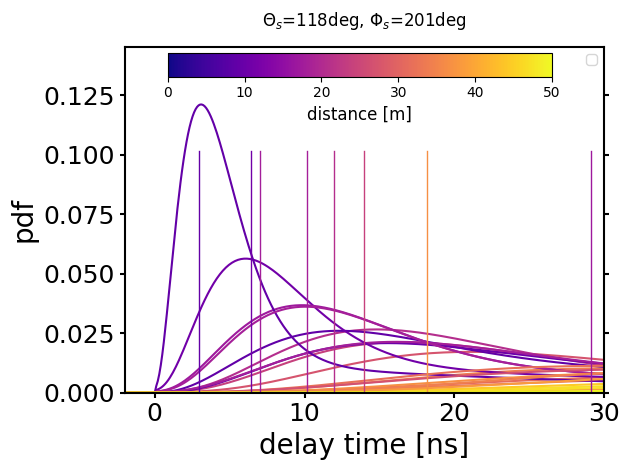

In [319]:
n = logits.shape[0]
cmap = plt.cm.plasma
c_map = plt.cm.ScalarMappable(norm=Normalize(vmin=0, vmax=50), cmap=cmap)

dists = np.array(closest_approach_dist)
cols = [c_map.to_rgba(dist) for dist in dists]

# create a batch of mixture distributions
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=a,    
            rate=b,
            force_probs_to_zero_outside_support=True
              )
    )

# vectorized plotting
xvals = np.linspace(-10, 1000, 10000)
xvals = xvals.reshape(10000, 1) # allow broadcasting along batch dimension
#xvals = np.repeat(xvals[np.newaxis,:], 20, axis=0).T

yvals = gm.prob(xvals)

fig, ax = plt.subplots()
ax.set_prop_cycle(color=cols)
plt.plot(xvals, yvals)

delay_times = dom_info_all['time'].values - (geo_time + meta['muon_time'])
print(delay_times)
for dt, col in zip(delay_times, cols):
    plt.axvline(float(dt), ymax=0.7, linewidth=1, color=col)

plot_args = {'xlim':[-2, 30],
                 'ylim':[0.0, 1.2 * np.amax(yvals)],
                 'xlabel':'delay time [ns]',
                 'ylabel':'pdf'}

zenith = np.rad2deg(meta['muon_zenith'])
azimuth = np.rad2deg(meta['muon_azimuth'])
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg", pad=15)
plt.tight_layout()
cax = fig.add_axes([0.27, 0.83, 0.6, 0.05])
cb = fig.colorbar(c_map, cax=cax, orientation='horizontal')
cb.set_label('distance [m]',fontsize=12)
plt.show()

In [320]:
print(np.sort(dists))

[  8.98131787   9.02828627  10.3309349   10.86504928  17.12499529
  17.79458983  18.01823465  20.65420114  23.87267863  24.24241529
  26.5711338   27.17547411  31.14719724  31.97977399  32.95620773
  34.17771033  34.2334867   36.62652859  37.73550066  38.17806078
  39.81421411  44.33932701  46.50796004  46.88352898  47.12991957
  49.54069624  54.26893114  58.13143309  62.23958772  62.78405091
  63.39190535  67.29409326  67.84538709  75.23339238  84.58448405
  87.05803281  93.28990212  95.15040182  99.84870675 109.45875088
 125.75685323 147.82502141 166.19019659]


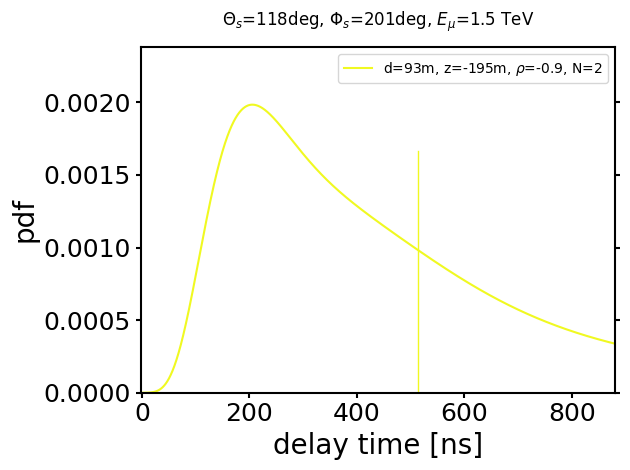

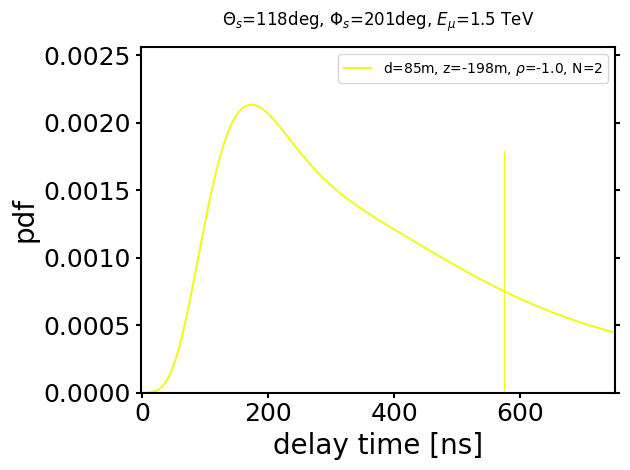

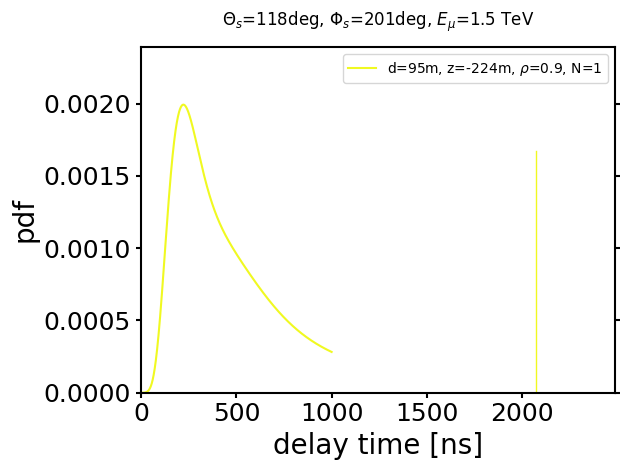

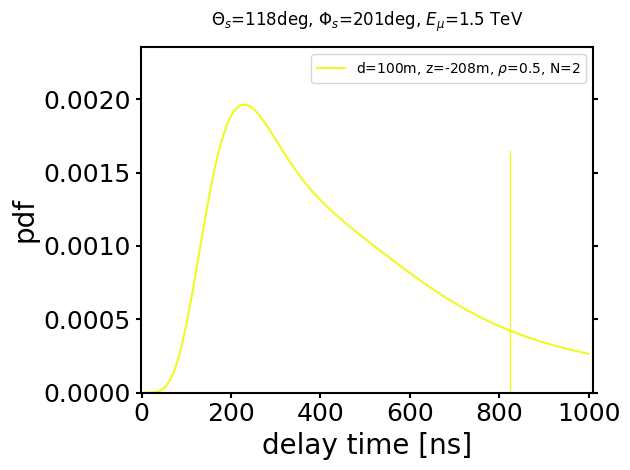

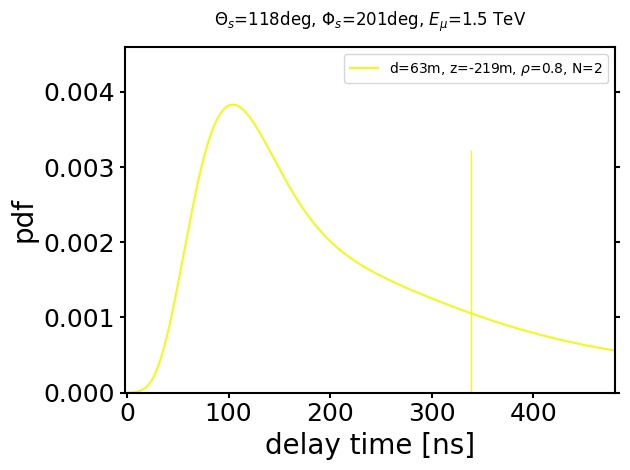

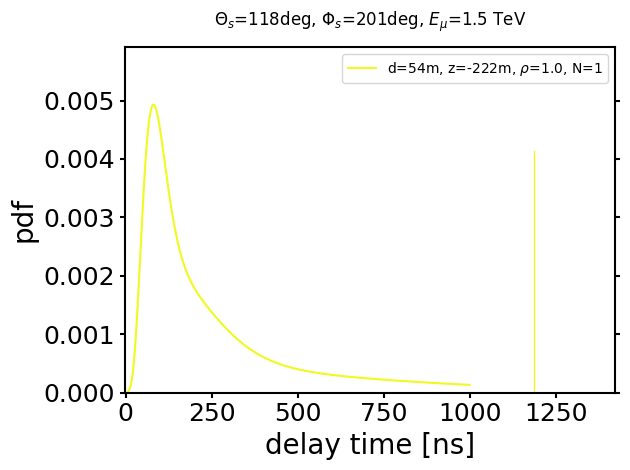

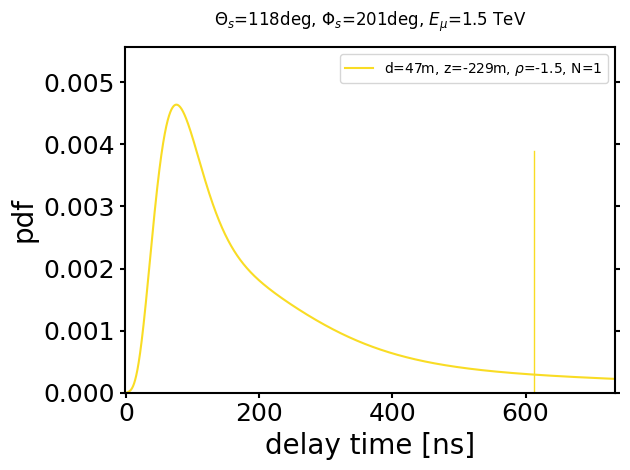

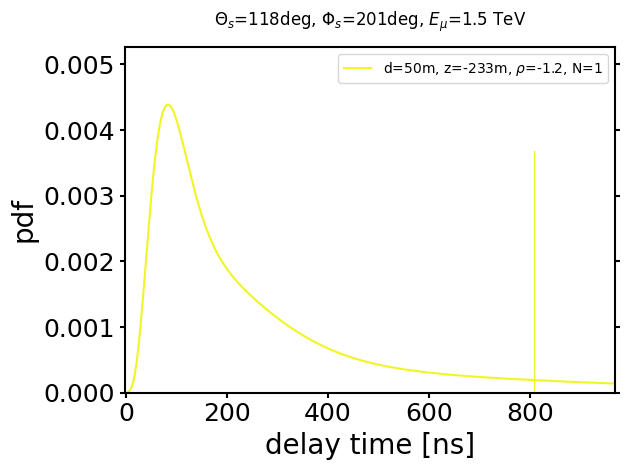

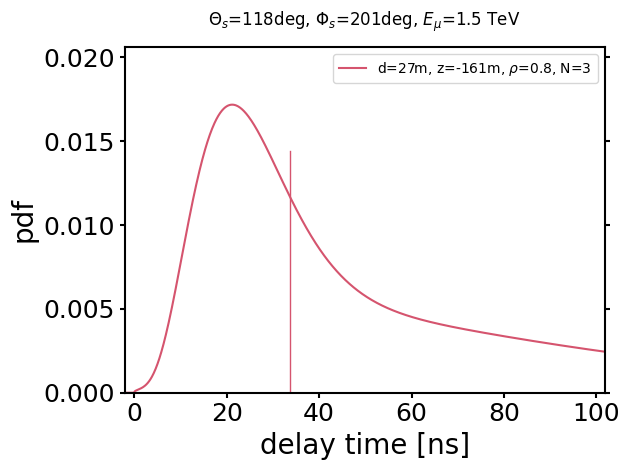

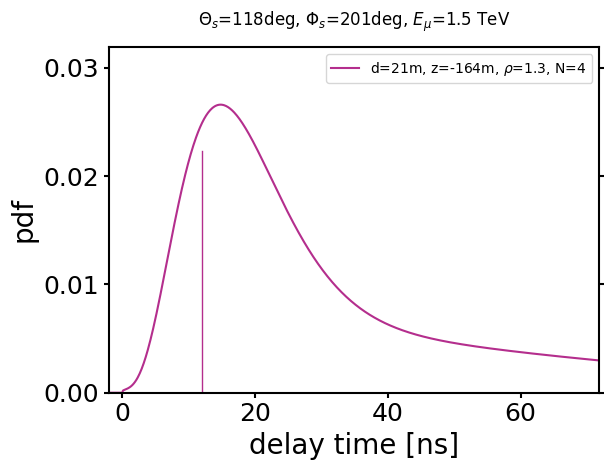

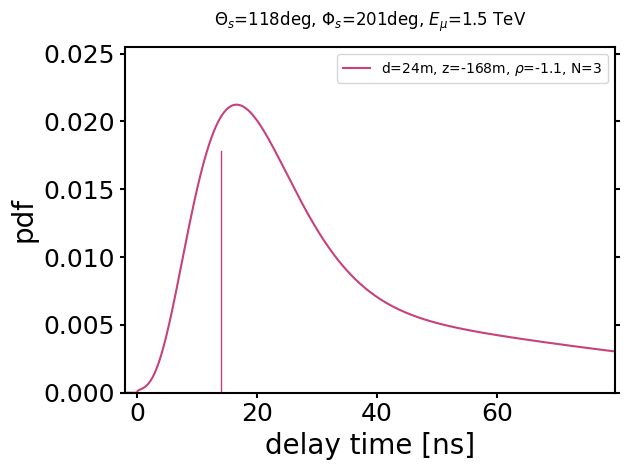

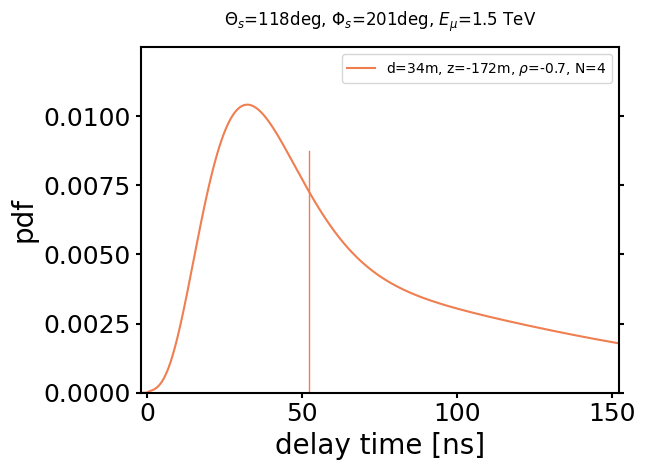

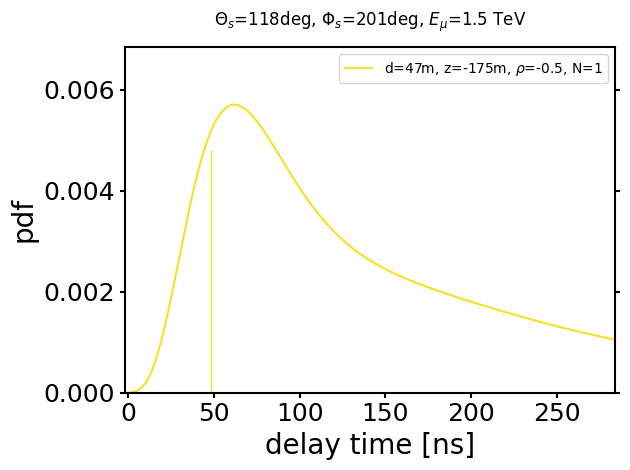

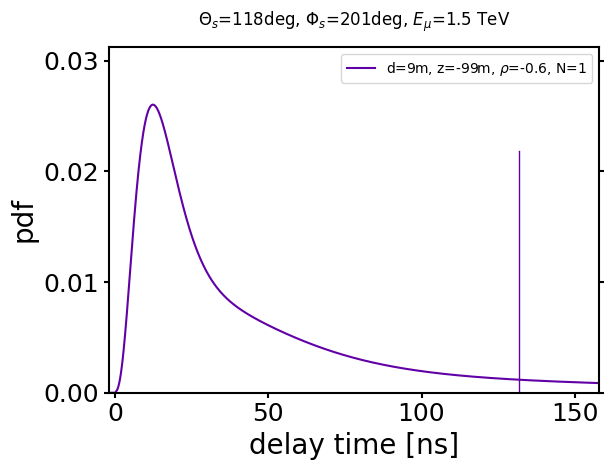

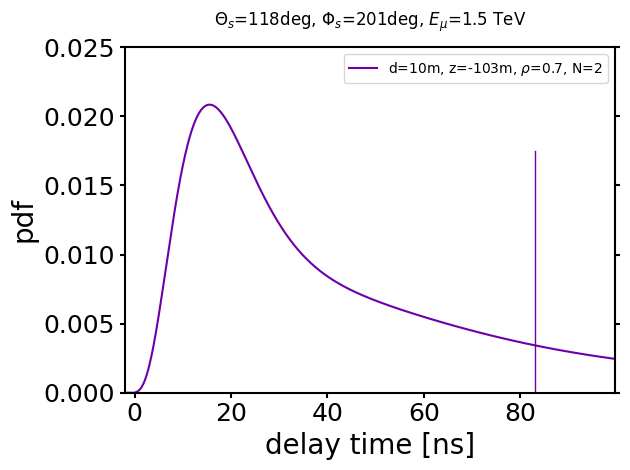

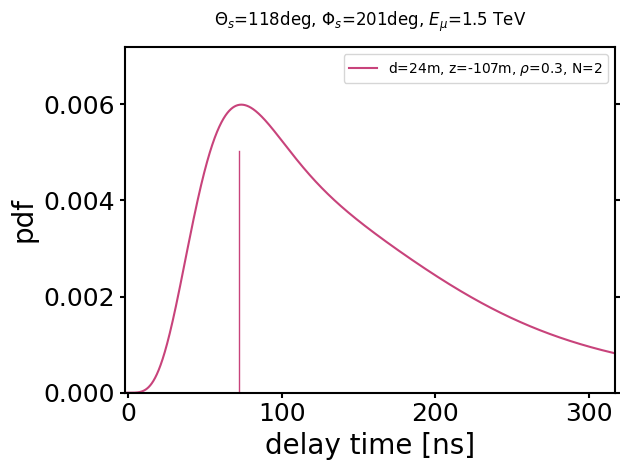

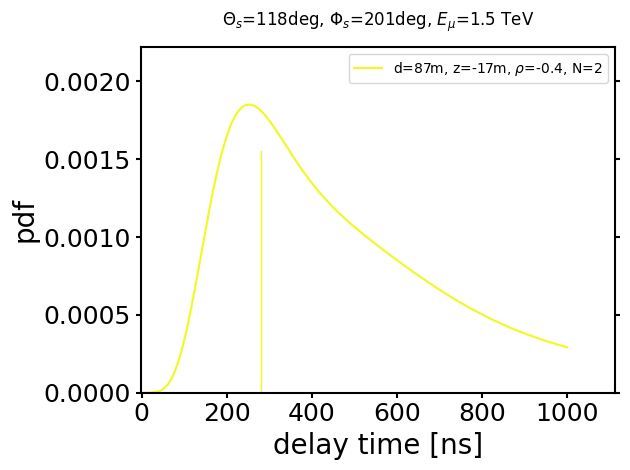

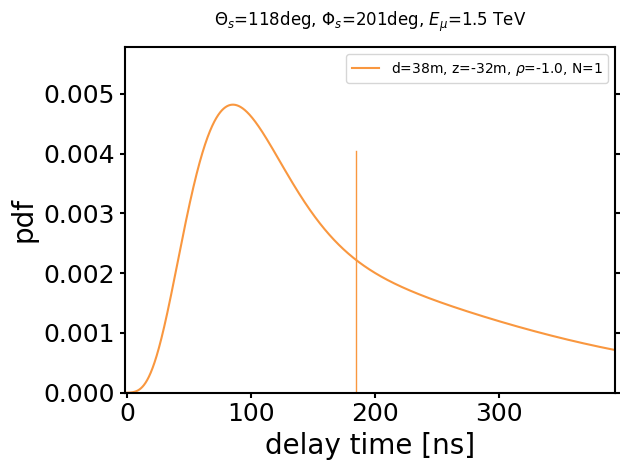

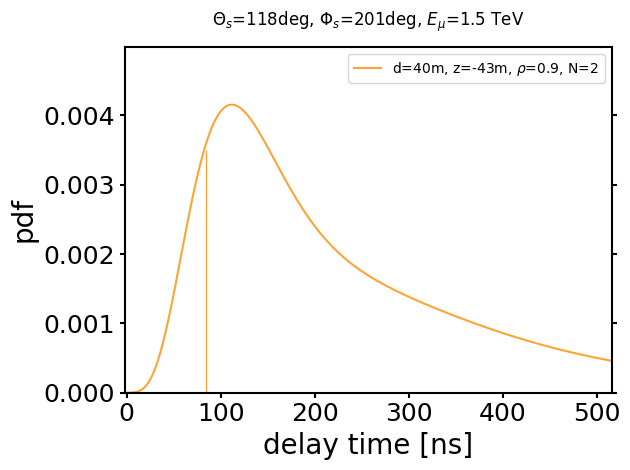

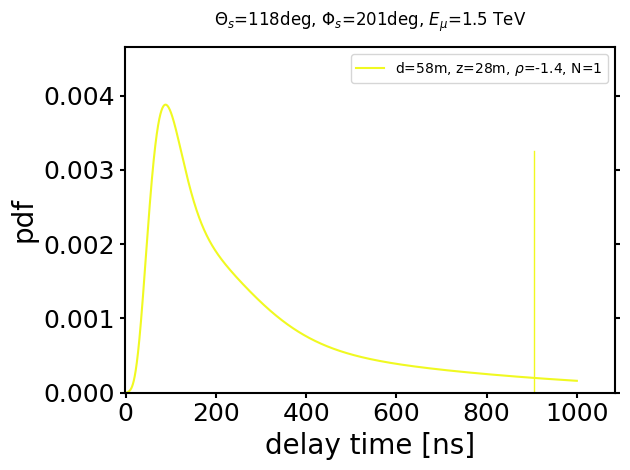

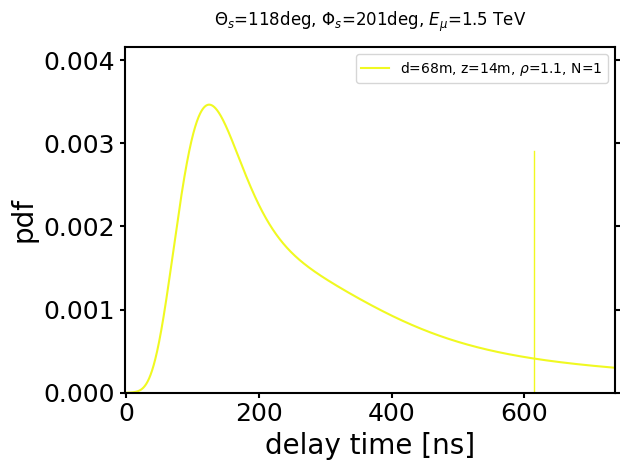

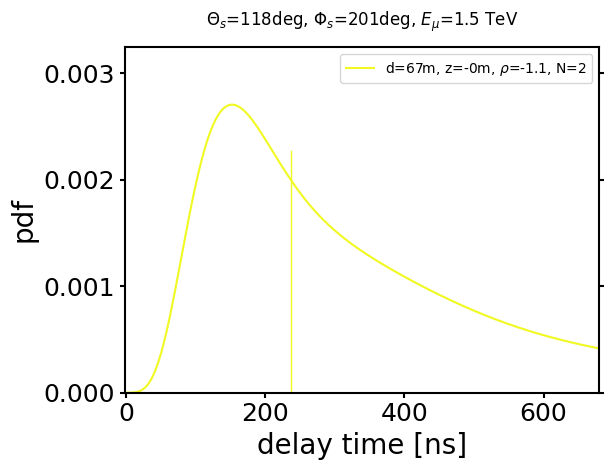

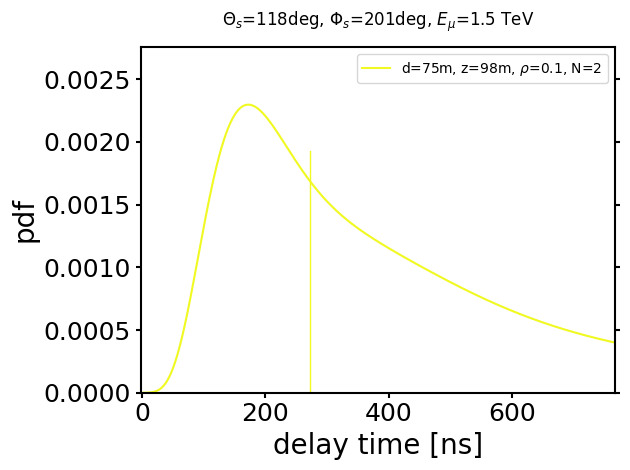

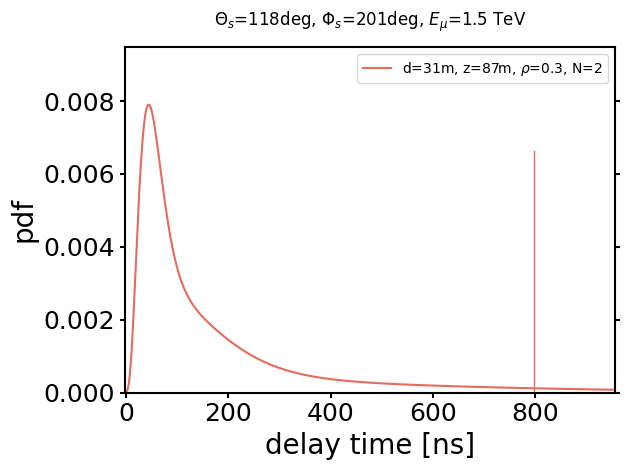

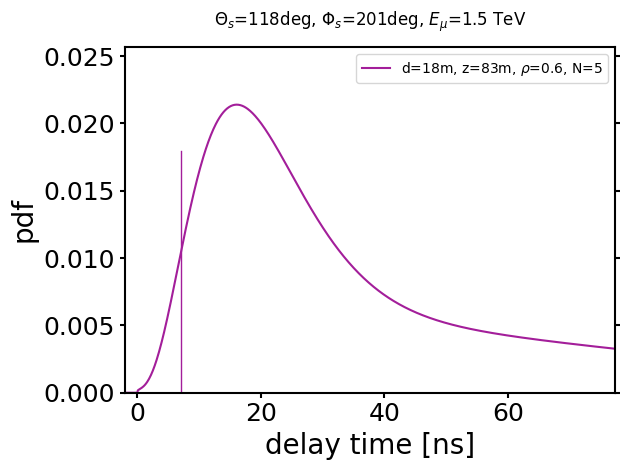

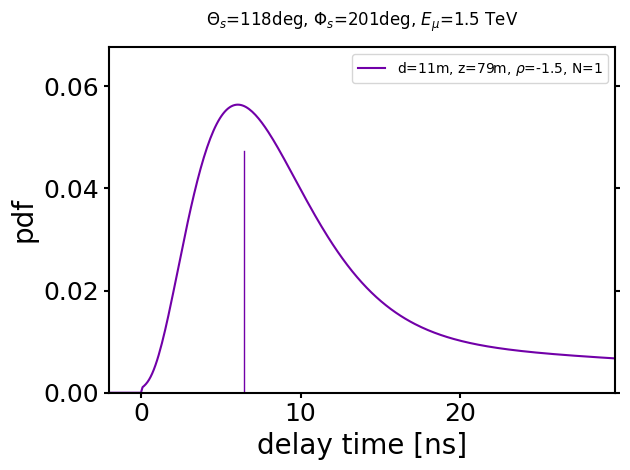

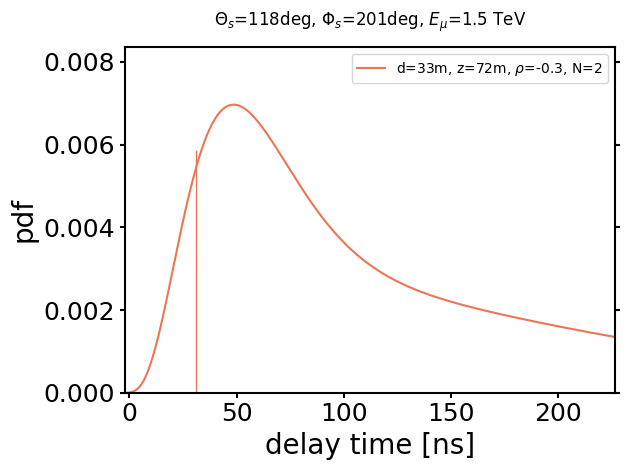

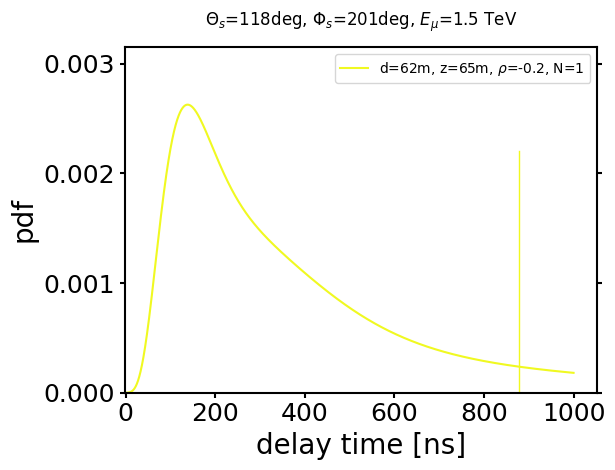

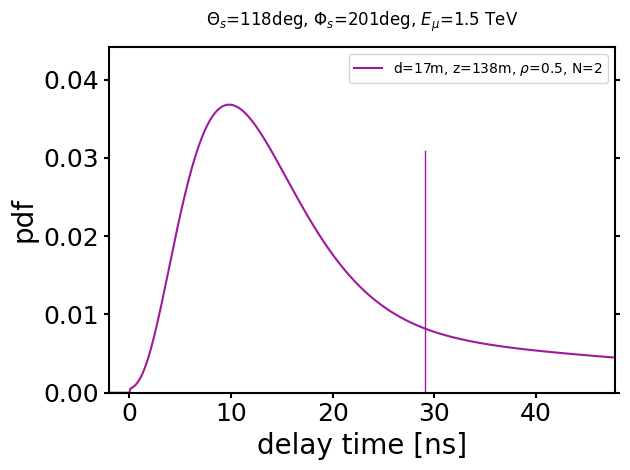

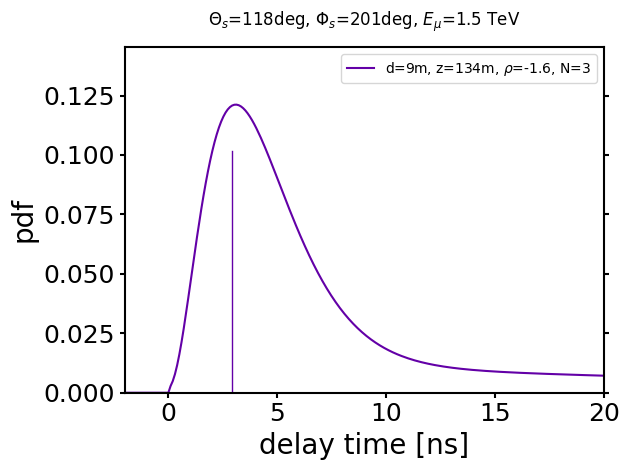

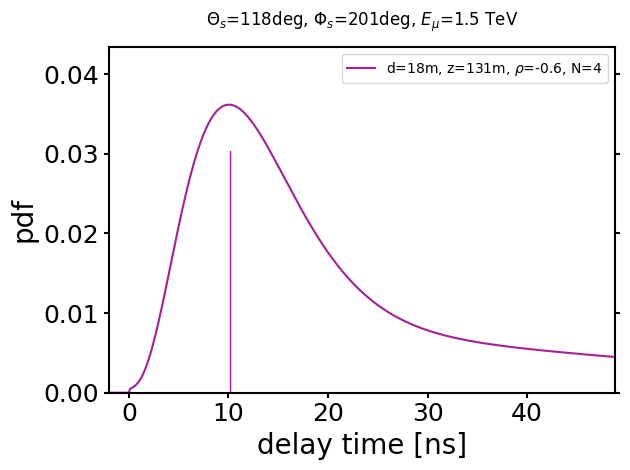

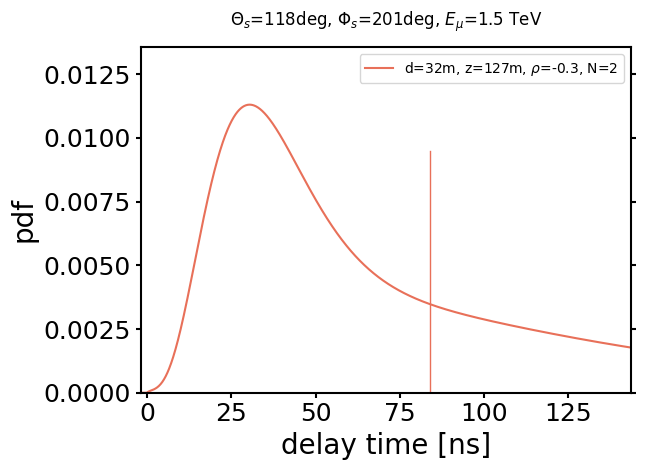

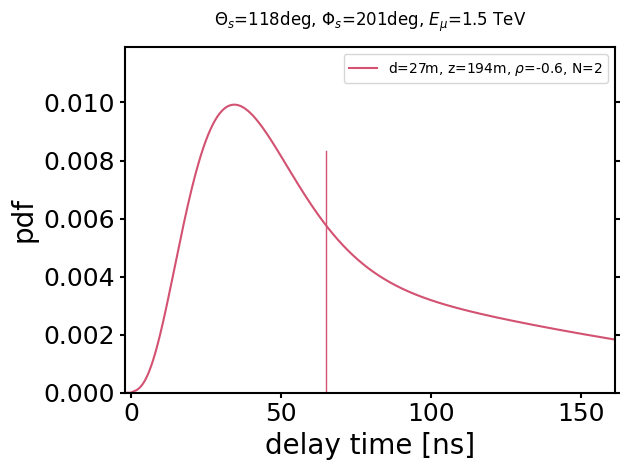

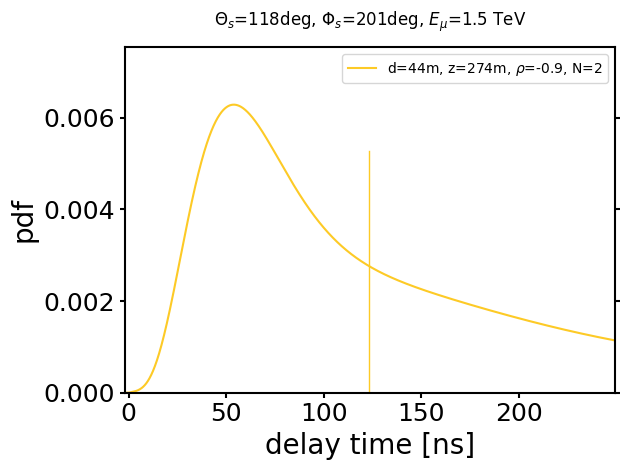

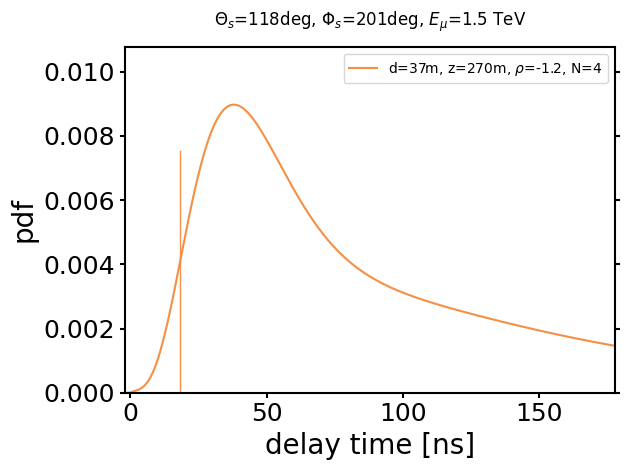

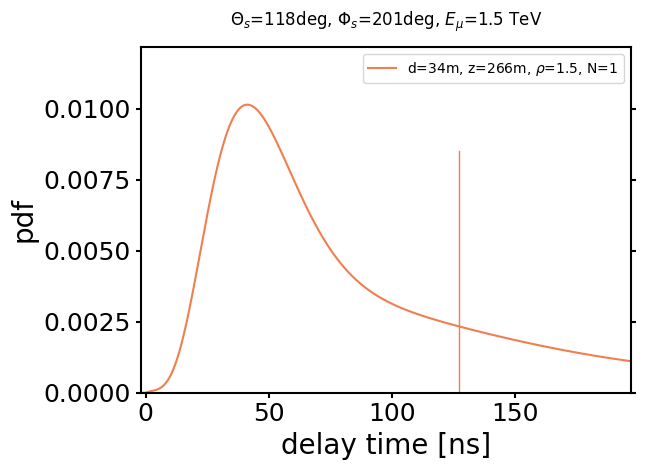

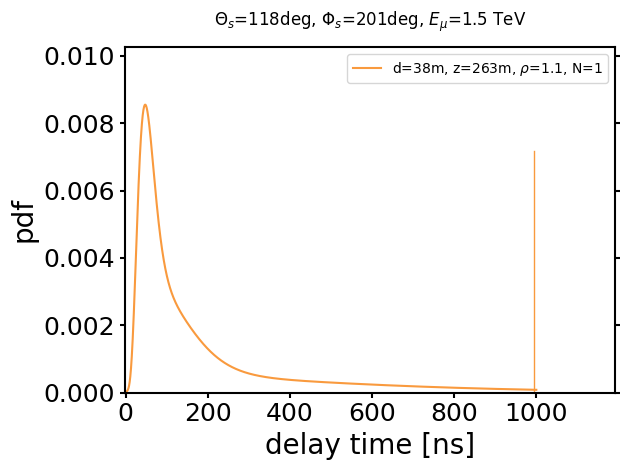

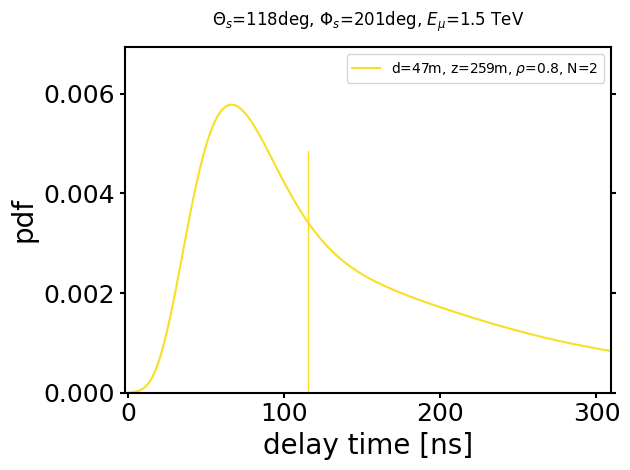

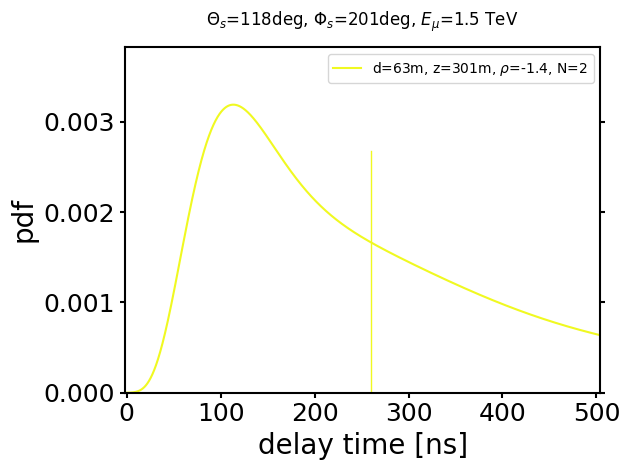

In [322]:
delay_times = dom_info_all['time'].values - (geo_time + meta['muon_time'])
xvals = np.linspace(-10, 1000, 10000)
qtots = dom_info['charge'].values

for i, yval in enumerate(yvals.T):
    if dists[i] > 100:
        continue
        
    fig, ax = plt.subplots()
    plt.plot(xvals, yval, color=cols[i], label=f'd={dists[i]:.0f}m, z={float(closest_approach_z[i]):.0f}m, $\\rho$={float(closest_approach_rho[i]):.1f}, N={qtots[i]:.0f}')
    
    
    plt.axvline(x=float(delay_times[i]), ymax=0.7, linewidth=1, color=cols[i])
    
    plot_args = {'xlim':[-2, np.max([20, 5 * mode[i, 1], float(delay_times[i])*1.2])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
    zenith = np.rad2deg(meta['muon_zenith'])
    azimuth = np.rad2deg(meta['muon_azimuth'])
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.title(f"$\\Theta_s$={zenith:.0f}deg, $\\Phi_s$={azimuth:.0f}deg, $E_\mu$={meta['muon_energy_at_detector']/1000:.1f} TeV", pad=15)
    plt.tight_layout()
    plt.show()

In [149]:
print(yvals.shape)

(10000, 58)
